# **Methods of calculating cylindrical coordinates**

The aim of this notebook is to demonstrate that the much more efficient package "xvortices" is just as effective at calculating the cylindrical coordinates around a tropical cyclone as the 'cylindrical_Mlev' which was developed by **John Ashcroft** and partially by **Amethyst Johnson** at the University of Leeds

### Import packages

In [43]:
from xvortices.xvortices import load_cylind, project_to_cylind
import xarray as xr
import numpy as np
import iris
import time
from iris.coords import DimCoord
from iris.cube import Cube
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings("ignore", category=FutureWarning); warnings.filterwarnings("ignore", category=UserWarning) 

### Define a small function for a nice subplot colorbar (optional)

In [36]:
# just adds a nice colorbar 
def add_colorbar(axes,im1,ticks):
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical',ticks=ticks)
    cbar.ax.set_yticklabels(ticks)

### Previously used functions for cylindrical coordinates

In [37]:
def cylindrical_Mlev(cube,cenlat,cenlon,max_r=300,dr=10):
    cyl_cube = []
    for cube_p in cube.slices(['latitude','longitude']):
        cube_slc_p = cylindrical_mlev(cube_p,cenlat,cenlon,max_r=max_r,dr=dr)
        cyl_cube.append(cube_slc_p)
    cube_cy = iris.cube.CubeList(cyl_cube).merge()[0]
    return cube_cy

def cylindrical_mlev(cube,cenlat,cenlon,max_r=300,dr=2):
    '''
    Converts an iris cube from a lat/lon grid to cylindrical coordinates.
    max_r and dr can be defined in the function.
    Should only be used on data in the tropics where the globe can be cansidered
    cartesian and hence the km_to_deg factor of 0.009... can be used.
    Written by John Ashcroft, University of Leeds
    '''
    dtheta = np.pi / 8. ## <<-- change this to make more accurate or make quicker
    radii = np.arange(0,max_r,dr)
    theta = np.arange(0,2*np.pi+0.0001,dtheta)
    km_to_deg = 0.009 # Fairly accurate for the tropics, calculated using a lat of 15 deg.
    mlev = cube.coord('model_level_number').points[0]
    radii_coord = iris.coords.AuxCoord(radii,long_name='r',units='km')
    theta_coord = iris.coords.AuxCoord(theta,long_name='phi')
    m_coord = iris.coords.AuxCoord(mlev,long_name='model_level_number')
    for r in radii:
      cube_rad = []
      for phi in theta:
          xpoi = cenlon + r * km_to_deg * np.cos(phi)
          ypoi = cenlat + r * km_to_deg * np.sin(phi) # coordinates of interest
          new_point = [('latitude',ypoi),('longitude',xpoi)] # Define a new location
          data = cube.interpolate(new_point,iris.analysis.Linear()).data #Linearly interpolate data form the cube to this point
          cube_rad.append(data) # Define array of data for each phi
      if r == 0:
          cyl_data = cube_rad
      else:
          cyl_data = np.vstack((cyl_data,cube_rad))
    cyl_cube = iris.cube.Cube(cyl_data,
          long_name='{0} in cylindrical coordinates'.format(cube.name()),
          aux_coords_and_dims=[(radii_coord,0),(theta_coord,1)],
          attributes={"cenlat":cenlat,"cenlon":cenlon})
    cyl_cube.add_aux_coord(m_coord)
    return cyl_cube

### Load in the data

In [38]:
file="/nfs/a161/eeajo/original/em0/umnsaa_pd000.pp"
w = iris.load_cube(file,'upward_air_velocity')[0] # loads in just one time
z = iris.load_cube(file,'height_above_reference_ellipsoid')

### Define central longitude and latitude

In [41]:
lat0 = 20.754039797516192; lon0 = 290.10739890026036

### Calculate cylindrical coordinates using original method

In [44]:
# Calculates cylindrical coordinates for vertical velocity and altitude, then means over the azimuth
init_time = time.perf_counter()
w_cb = cylindrical_Mlev(w,lat0,lon0,max_r=300,dr=5).collapsed('phi',iris.analysis.MEAN)
z_cb = cylindrical_Mlev(z,lat0,lon0,max_r=300,dr=5).collapsed('phi',iris.analysis.MEAN)
end_time = time.perf_counter()

print(end_time-init_time)

563.758245666977


### Calculate cylindrical coordinates using xvortices

In [45]:
# number of azimuthal gridpoints, number of radius gridpoints, maximum radius
# this is computed in degrees so I divide by 111 to convert to km
azimNum, radiNum, radMax = 72, 60, 300/111

init_time = time.perf_counter()
[z_xv,w_xv], lons, lats, etas = load_cylind([xr.DataArray.from_iris(z),xr.DataArray.from_iris(w)],
                                      azimNum=azimNum,radiNum=radiNum,radMax=radMax,
                                      olon=lon0, olat=lat0,lonname="longitude",latname="latitude")
end_time = time.perf_counter()

print(end_time-init_time)

0.08175429189577699


### xarray to iris doesn't properly configure the coordinates - remove and reset

In [46]:
phi = DimCoord(np.linspace(0, 355, 72),long_name='phi',units='degrees')
r = DimCoord(np.linspace(0, 300/111, 60)*111,long_name='r',units='km')
model_level_number = w.coord('model_level_number')

def reset_coords(xarray_input,times=False):
    w_is = xarray_input.to_iris()
    w_is.remove_coord('model_level_number'); w_is.remove_coord('azim'); w_is.remove_coord('radi')
    w_cube = Cube(np.array(w_is.data,dtype=float),
                  long_name="w in cylindrical coordinates",
                  dim_coords_and_dims=[(model_level_number,0),(r,1),(phi,2)])
    return(w_cube)

# also means across the azimuth
w_cyl = reset_coords(w_xv).collapsed('phi',iris.analysis.MEAN)
z_cyl = reset_coords(z_xv).collapsed('phi',iris.analysis.MEAN)

### Plot to demonstrate similarity between the methods

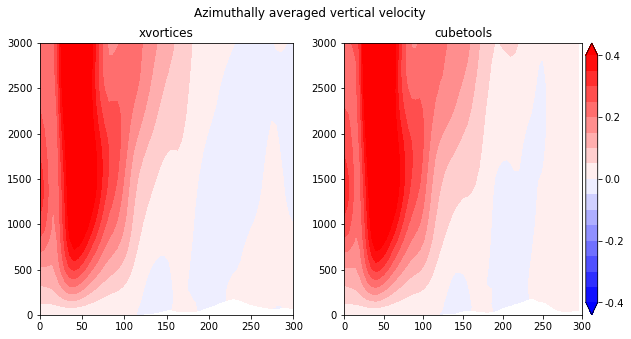

In [48]:
fig, ((ax1),(ax2)) = plt.subplots(1,2,figsize=(10,5))
X,Y=np.meshgrid(r.points,model_level_number.points)
shad = ax1.contourf(X,z_cyl.data,w_cyl.data,levels=np.arange(-0.4,0.45,0.05),cmap="bwr",extend="both")
ax1.set_title("xvortices"); ax1.set_ylim(0,3000); ax1.set_xlim(0,300)

X,Y=np.meshgrid(w_cb.coord('r').points,w_cb.coord('model_level_number').points)
shad = ax2.contourf(X,z_cb.data,w_cb.data,levels=np.arange(-0.4,0.45,0.05),cmap="bwr",extend="both")
ax2.set_title("cubetools"); ax2.set_ylim(0,3000); ax2.set_xlim(0,300)
plt.suptitle("Azimuthally averaged vertical velocity")
add_colorbar(ax2,shad,ticks=np.round(np.arange(-0.4,0.6,0.2),2))
plt.show()